In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from itertools import product
from scipy.stats import lognorm, norm
from sklearn.linear_model import LinearRegression 



DATA_DIR = Path('../data')
MODEL_DIR = Path('../models')



# Import Distribution Models

In [10]:
# Set up

with open(MODEL_DIR / 'siju_lognorm_fits.json', 'r') as infile:
    siju_lognorm_fits = json.load(infile)
    
with open(MODEL_DIR / 'hije_norm_fits.json', 'r') as infile:
    hije_norm_fits = json.load(infile)
    
lobes = ["alpha'1", "alpha'2", "alpha'3", 'alpha1', 'alpha2', 'alpha3',
       "beta'1", "beta'2", 'beta1', 'beta2', 'gamma1', 'gamma2', 'gamma3',
       'gamma4', 'gamma5']
stimuli = ['citronella', 'ethanol', 'heptanone', 'hexanol', 'mch', 'octanol',
       'peppermint', 'vinegar', 'yeast']

# Visualise Models

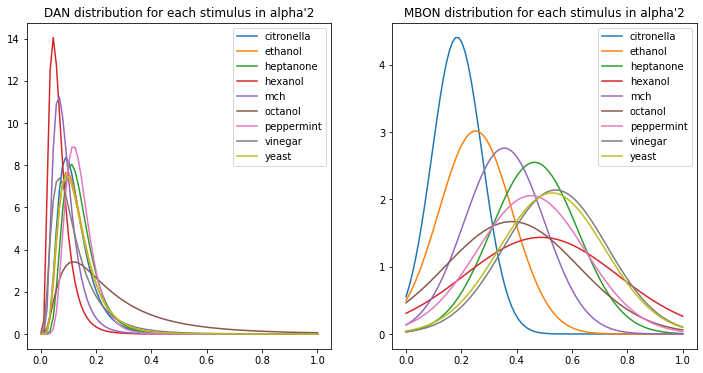

In [34]:
lobe = lobes[1]
x = np.linspace(0,1,90)

fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].set_title(f'DAN distribution for each stimulus in {lobe}')
axes[1].set_title(f'MBON distribution for each stimulus in {lobe}')

for stimulus in stimuli:
    
    siju_params = siju_lognorm_fits[lobe][stimulus]
    siju_rv = lognorm(s=siju_params[0], loc=siju_params[1], scale=siju_params[2])
    y = siju_rv.pdf(x)
    axes[0].plot(x, y, label=stimulus)
        
    hije_params = hije_norm_fits[lobe][stimulus]
    hije_rv = norm(loc=hije_params[0], scale=hije_params[1])
    y = hije_rv.pdf(x)
    axes[1].plot(x, y, label=stimulus)

axes[0].legend()
axes[1].legend()

plt.show()

# Build data matrix from distributions

In [72]:
samples_per_stimulus = 1000

X = np.zeros([len(stimuli) * samples_per_stimulus, len(lobes)])
Y = np.zeros([len(stimuli) * samples_per_stimulus, len(lobes)])

for i, stimulus in enumerate(stimuli):
    for j, lobe in enumerate(lobes):
        mbon_params = hije_norm_fits[lobe][stimulus]
        dan_params = siju_lognorm_fits[lobe][stimulus]
        
        mbon_rv = norm(loc=mbon_params[0], scale=mbon_params[1])
        dan_rv = lognorm(s=dan_params[0], loc=dan_params[1], scale=dan_params[2])
        
        X[i*samples_per_stimulus:(i+1)*samples_per_stimulus, j] = dan_rv.rvs(samples_per_stimulus)
        Y[i*samples_per_stimulus:(i+1)*samples_per_stimulus, j] = mbon_rv.rvs(samples_per_stimulus)        
        

# Linear Fit (one-to-one)

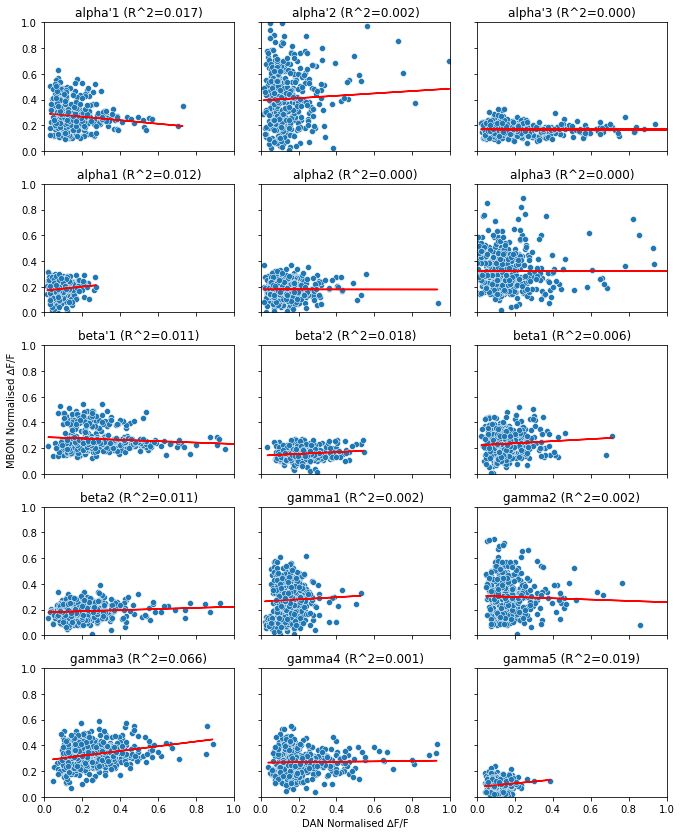

In [73]:
model_parameters = {}
score_dict = {}

if samples_per_stimulus < 60:
    fig, axes = plt.subplots(5, 3, figsize=(10,12), sharex='all', sharey='all')
# fig.suptitle('DAN vs MBON activity Model using Linear Regression')

for i, lobe in enumerate(lobes):
    
    x = X[:, i]
    y = Y[:, i]
    
    xT = x.reshape((-1,1))
    model = LinearRegression(fit_intercept=True).fit(xT, y)
    score = model.score(xT, y)

    score_dict[lobe] = score
    
    model_parameters[lobe] = {
        'm': model.coef_,
        'c': model.intercept_,
        'r2': score
    }
    
    if samples_per_stimulus < 60:
        ax = axes[int(i/3), i%3]
        ax.set_title(f'{lobe} (R^2={score:.3f})')
        ax.set_ylim([0,1])
        ax.set_xlim([0,1])

        ax.plot(xT, model.predict(xT), 'r')
        sns.scatterplot(
            x = x,
            y = y,
            ax=ax
        )

# Add common axis labels
if samples_per_stimulus < 60:
    fig.add_subplot(111, frameon=False)  
    plt.grid(False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel('DAN Normalised ∆F/F')
    plt.ylabel('MBON Normalised ∆F/F')

    plt.tight_layout()

In [63]:
print(f'Mean score: {np.mean(list(score_dict.values()))}')

Mean score: 0.009349478127760599


In [64]:
SCORE_DIR = Path('../scores')

file_name = 'canonical_linear_model-distribution_data-'+ str(samples_per_stimulus) +'.json'

with open( SCORE_DIR / file_name, "w") as score_file:
    json.dump(score_dict, score_file, indent='\t')

## Linear Model (Cross Talk)

In [65]:
# Fit each of the lobes seperately
models = []
scores = {}

for i, lobe in enumerate(lobes):
    y = Y[:,i]
    model = LinearRegression(fit_intercept=True).fit(X, y)
    score = model.score(X, y)
    print(f'score for {lobe}: {score}')

    models.append(model)
    scores[lobe] = score

print(f'Average score: {np.mean(list(scores.values()))}')


score for alpha'1: 0.07738113052329687
score for alpha'2: 0.09238413892642372
score for alpha'3: 0.09313241714150078
score for alpha1: 0.05664636909649834
score for alpha2: 0.06387360011370435
score for alpha3: 0.08143658984129076
score for beta'1: 0.15903396957899307
score for beta'2: 0.04887752447005267
score for beta1: 0.07996409046999053
score for beta2: 0.05230339262868622
score for gamma1: 0.1847595512557847
score for gamma2: 0.09518271896846009
score for gamma3: 0.13661459589903613
score for gamma4: 0.21681710072482774
score for gamma5: 0.05434419948222591
Average score: 0.09951675927471812


In [66]:
file_name = 'crossed_linear_model-distribution_data-'+ str(samples_per_stimulus) +'.json'

with open( SCORE_DIR / file_name, "w") as score_file:
    json.dump(scores, score_file, indent='\t')

# Check the scores man

In [68]:
with open( SCORE_DIR / 'canonical_linear_model-distribution_data-1000.json', "r") as score_file:
    score_canonical = json.load(score_file)

with open( SCORE_DIR / 'crossed_linear_model-distribution_data-1000.json', "r") as score_file:
    score_crossed = json.load(score_file)

In [69]:
score_df = pd.concat(
    [pd.Series(score_canonical, name='canonical score'), 
    pd.Series(score_crossed, name='crossed score') ],
    axis=1
)

score_df

,canonical score,crossed score
alpha'1,0.004980,0.077381
alpha'2,0.000873,0.092384
alpha'3,0.000005,0.093132
alpha1,0.006064,0.056646
alpha2,0.000009,0.063874
alpha3,0.000175,0.081437
beta'1,0.001073,0.159034
beta'2,0.010436,0.048878
beta1,0.004636,0.079964
beta2,0.015102,0.052303


In [70]:
# Basic stats
score_df.describe()

,canonical score,crossed score
count,15.000000,15.000000
mean,0.009349,0.099517
std,0.015520,0.051545
min,0.000005,0.048878
25%,0.000547,0.060260
50%,0.004636,0.081437
75%,0.008653,0.115899
max,0.059364,0.216817


<AxesSubplot:xlabel='lobe'>

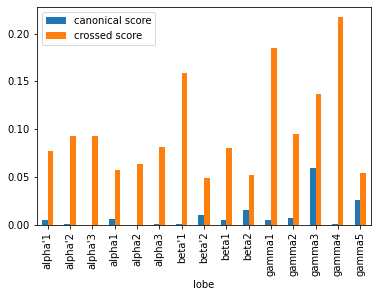

In [71]:
# Visual comparison

score_df["lobe"] = score_df.index
score_df.plot(x="lobe", y=["canonical score", "crossed score"], kind="bar")